Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)


Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive/Skin_Data_Store"


Test  Train


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset

# Define correct paths
path_to_train_directory = "/content/gdrive/MyDrive/Skin_Data_Store/Train"
path_to_test_directory = "/content/gdrive/MyDrive/Skin_Data_Store/Test"

# Convert to pathlib Path objects
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

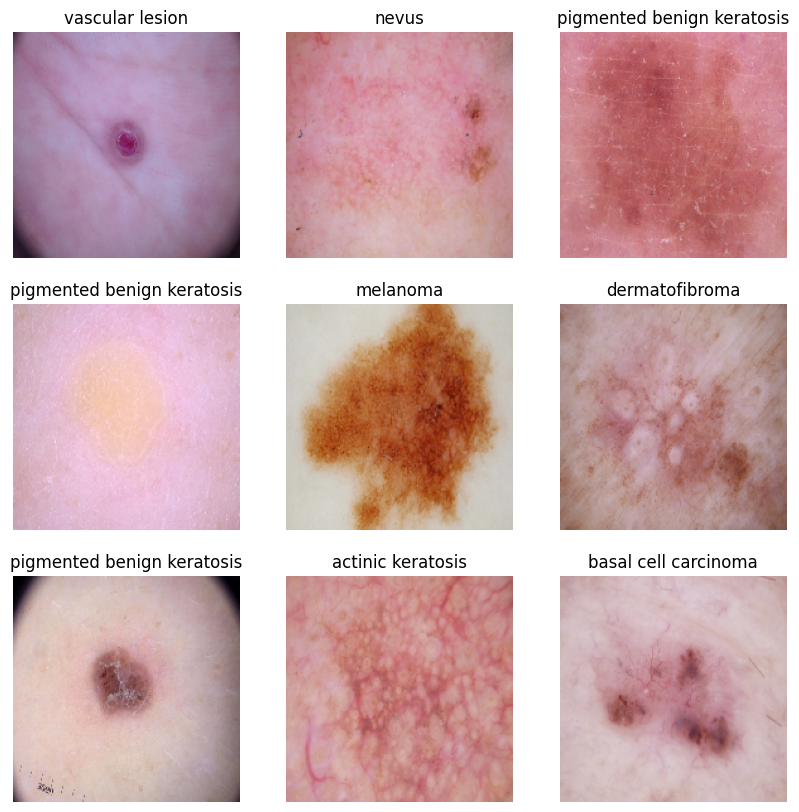

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

# Take one batch from train_ds and visualize the first 9 images
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")


plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
preprocessing_layers = [
    layers.Rescaling(1./255, input_shape=(180, 180, 3))
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Activation, Dropout
from tensorflow.keras.layers import Rescaling  # Import Rescaling properly
import tensorflow as tf

# Initialize the model
model = Sequential()

# Normalize pixel values to range [0,1] and define input shape
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))  # Fixed Rescaling import

# First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Second convolutional layer with 32 filters, 3x3 kernel, ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))

# Max pooling layer to reduce spatial dimensions
model.add(MaxPool2D(pool_size=(2, 2)))

# Second convolutional block
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Third convolutional block
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten the feature maps into a 1D vector
model.add(Flatten())

# Fully connected dense layer with 512 neurons and ReLU activation
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 1 neuron (binary classification) and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

# Print model summary to view the architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 176, 176, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 88, 88, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 86, 86, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 86, 86, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 41, 41, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      26,214,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,318,689 (100.40 MB)

 Trainable params: 26,318,305 (100.40 MB)

 Non-trainable params: 384 (1.50 KB)

### Train the model

In [16]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.1547 - loss: -17244.4473 - val_accuracy: 0.1499 - val_loss: -62653.2266
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1729 - loss: -461507.7500 - val_accuracy: 0.1499 - val_loss: -757370.0625
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1870 - loss: -2161705.0000 - val_accuracy: 0.1499 - val_loss: -2739803.0000
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1658 - loss: -6011709.5000 - val_accuracy: 0.1499 - val_loss: -7661058.5000
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.1698 - loss: -12526266.0000 - val_accuracy: 0.1499 - val_loss: -15861196.0000
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1804 - loss: -22457132.0000 - val_accuracy: 0.1499 - val_loss: -30523154.0000
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1770 - loss: -35734808.0000 - val_accuracy: 0.1499 - val_loss: -35415956.0000
Epoch 8/20
56

### Visualizing training results

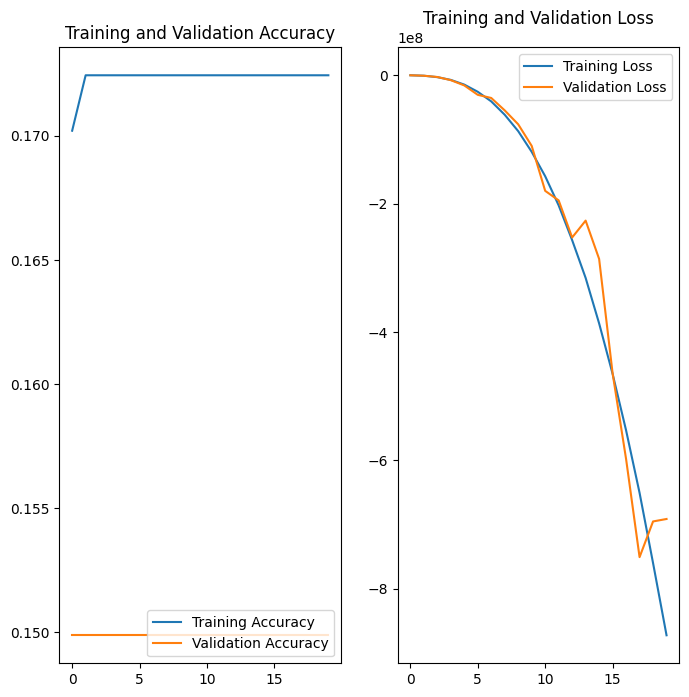

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

train_loss, train_acc = model.evaluate(train_ds, verbose=1)

val_loss, val_acc = model.evaluate(val_ds, verbose=1)

# Print results with better formatting

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")




56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1710 - loss: -677576192.0000
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1446 - loss: -686446080.0000
Training Accuracy: 0.1724
Validation Accuracy: 0.1499
Training Loss: -677322624.0000
Validation Loss: -691306368.0000


#The model is underfitting because accuracy is low and the Loss values are extremely negative . Overfitting happens when training accuracy is high but validation accuracy is low but the above values are relatively close resulting in underfitting

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define correct paths
path_to_train_directory = "/content/gdrive/MyDrive/Skin_Data_Store/Train"
path_to_test_directory = "/content/gdrive/MyDrive/Skin_Data_Store/Test"

# Convert to pathlib Path objects
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)


# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# Class names
image_class = [
    'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma',
    'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',
    'squamous cell carcinoma', 'vascular lesion'
]

# Load training data
train_batches = datagen.flow_from_directory(
    data_dir_train,
    target_size=(180, 180),
    classes=image_class,
    class_mode='categorical',
    batch_size=64,
    shuffle=True
)

# Load validation data
valid_batches = datagen.flow_from_directory(
    data_dir_test,
    target_size=(180, 180),
    classes=image_class,
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)




Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


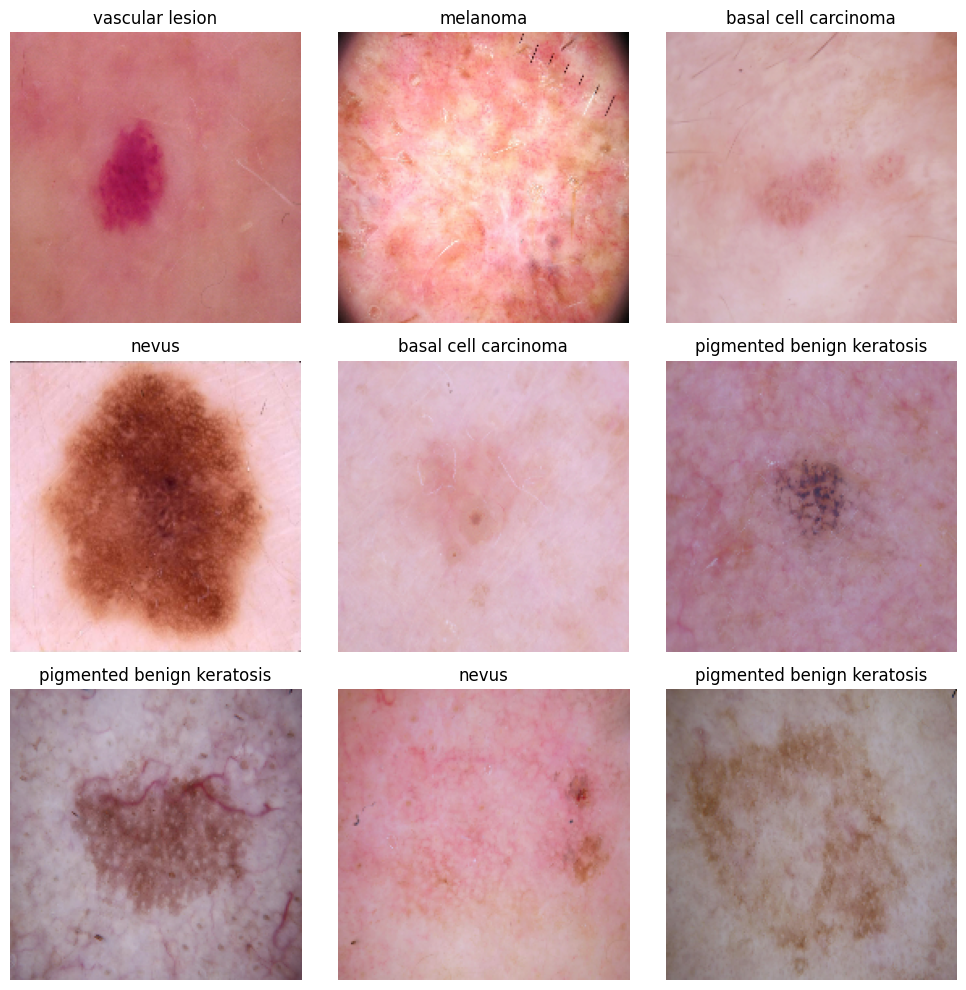

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.


plt.figure(figsize=(10, 10))

# Take one batch from train_ds
for images, labels in train_ds.take(1):
    num_images = min(9, images.shape[0])  # Ensure we don't exceed batch size

    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
        plt.title(class_names[labels[i].numpy()])  # Convert tensor label to integer
        plt.axis("off")

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

input_shape=(180, 180, 3)
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 180, 180, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 43, 43, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 21, 21, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 56448)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      28,901,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,045,929 (110.80 MB)

 Trainable params: 29,045,929 (110.80 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model

In [22]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])





In [23]:
# Set a learning rate annealer
from tensorflow.keras.callbacks import ReduceLROnPlateau



# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001
)



### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs


# Train model
epochs = 20
history = model.fit(
    train_batches,
    epochs=epochs,
    verbose=1,
    validation_data=valid_batches,
    callbacks=[learning_rate_reduction]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.1410 - loss: 159.4355 - val_accuracy: 0.1186 - val_loss: 2.1879 - learning_rate: 0.0010
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.2215 - loss: 2.0838 - val_accuracy: 0.1610 - val_loss: 2.1427 - learning_rate: 0.0010
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.2971 - loss: 1.9567 - val_accuracy: 0.2203 - val_loss: 2.0598 - learning_rate: 0.0010
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3440 - loss: 1.8391 - val_accuracy: 0.2034 - val_loss: 2.0629 - learning_rate: 0.0010
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.3331 - loss: 1.8966 - val_accuracy: 0.1695 - val_loss: 2.0895 - learning_rate: 0.0010
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3632 - loss: 1.7620
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3633 - loss: 1.7617 - val_accuracy:

### Visualizing the results

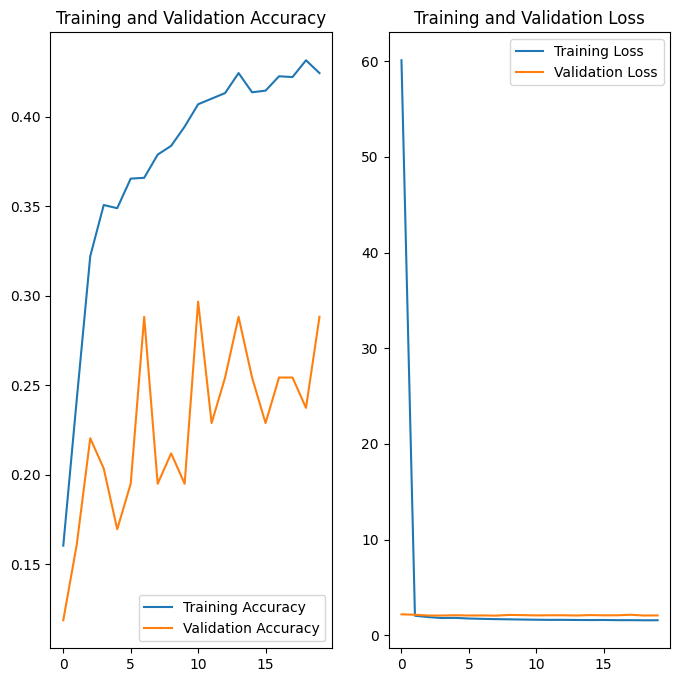

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# Ensure labels are one-hot encoded to match the model's output shape
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=9)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=9)))

# Evaluate the model
evaluation_results = model.evaluate(train_ds, verbose=1)
loss, accuracy = evaluation_results[:2]

evaluation_results_v = model.evaluate(val_ds, verbose=1)
loss_v, accuracy_v = evaluation_results_v[:2]

print("Accuracy:", accuracy)
print("Validation Accuracy:", accuracy_v)
print("Loss:", loss)
print("Validation Loss:", loss_v)


56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4225 - loss: 1.5635
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.4565 - loss: 1.5047
Accuracy: 0.4296875
Validation Accuracy: 0.4340044856071472
Loss: 1.5603629350662231
Validation Loss: 1.5693531036376953


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The second model is the better one as it achieved higher accuracy and stable loss, showing improved generalization.
there is still some evidence of slight overfitting as the validation accuracy slightly lags behind training accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 1000x1000 with 0 Axes>

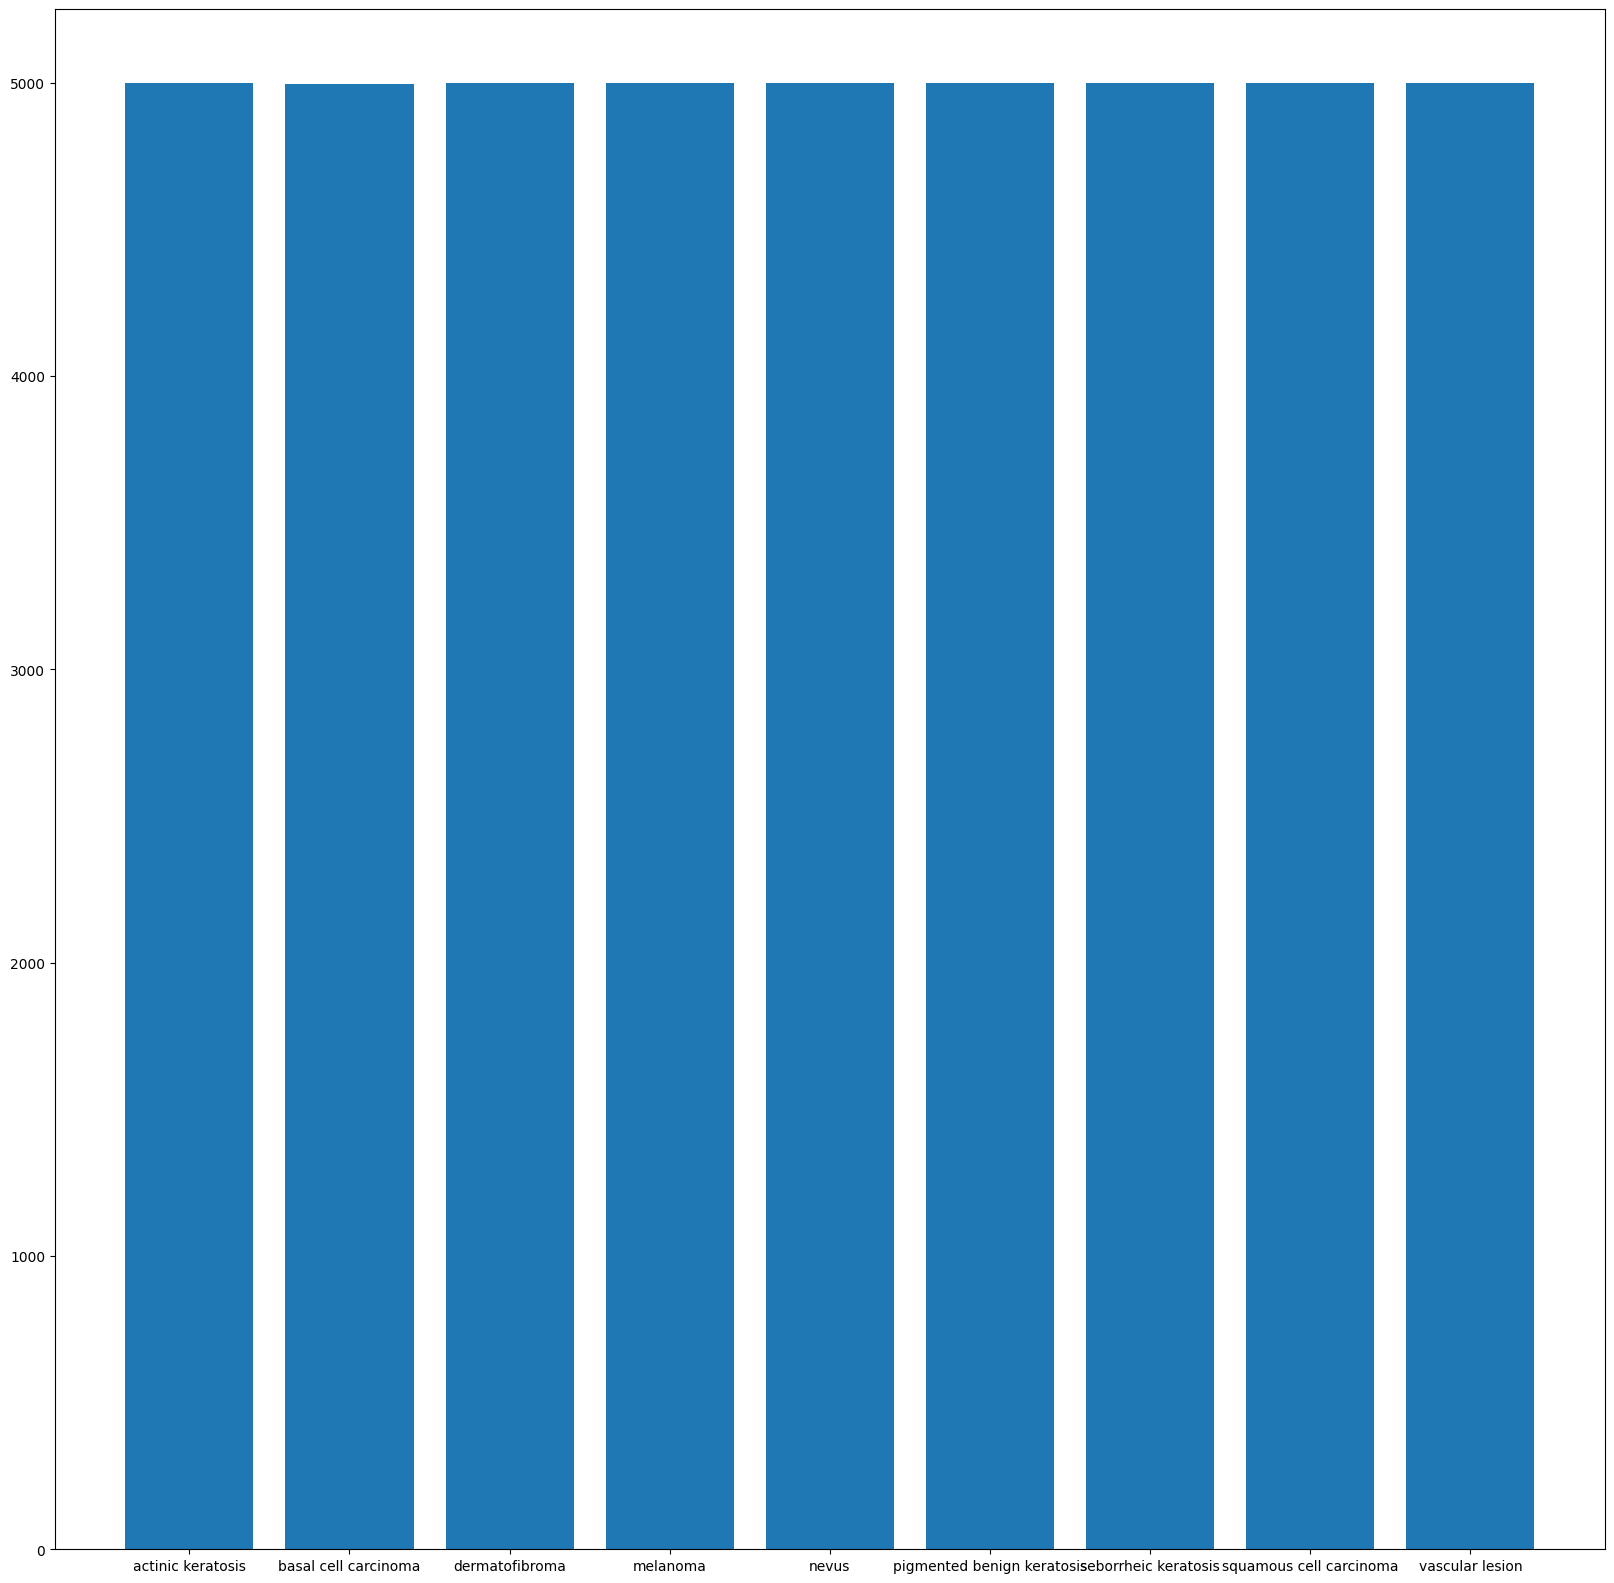

In [39]:
import matplotlib.pyplot as plt
data = {i: [] for i in class_names}

plt.figure(figsize=(10, 10))

for images, labels in train_ds:
    for i in range(len(labels)):
        label = labels[i].numpy().item()  # Convert tensor to scalar
        if label < len(class_names):  # Ensure valid index
            data[class_names[label]].append(images[i].numpy().astype("uint8"))

for i in data:
    data[i] = len(data[i])  # Count the occurrences

f = plt.figure(figsize=(20, 20))
plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?



dermatofibroma has the least number of samples

"melanoma,pigmented benign keratosis has the highest number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [40]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [41]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin_Data_Store/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC84028D1D0>: 100%|██████████| 500/500 [00:24<00:00, 20.42 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC840157810>: 100%|██████████| 500/500 [00:17<00:00, 27.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC84016A610>: 100%|██████████| 500/500 [00:19<00:00, 25.79 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7EC84010ACD0>: 100%|██████████| 500/500 [01:16<00:00,  6.50 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC84252DB50>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EC840261D90>: 100%|██████████| 500/500 [00:17<00:00, 28.47 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7EC8401ED4D0>: 100%|██████████| 500/500 [00:39<00:00, 12.79 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC8425032D0>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_Data_Store/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EC80E57FE10>: 100%|██████████| 500/500 [00:18<00:00, 27.52 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [42]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)



4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [43]:
import glob

path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list



['/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0010476.jpg_6edebf6c-3bd0-4393-a725-7d7ee0f6d58e.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0000169.jpg_0946e7ae-2f3d-4807-a03d-c60e3e172b98.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0011045.jpg_1c167453-f452-4c2e-b231-8e1687a53ad5.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0010783.jpg_3d8b4f96-1f3c-4b35-ac26-985b47299b71.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0000462.jpg_760e88be-09e0-41de-9dd2-80e43b2a4553.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0010313.jpg_e7727630-2c96-4a71-be36-0d5bb448e3e1.jpg',
 '/content/gdrive/MyDrive/Skin_Data_Store/Train/melanoma/output/melanoma_original_ISIC_0010391.jpg_f5b5b4ce-f956-4fc9-8de4-c309cd058fb0.jpg',
 '/con

In [44]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [45]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [47]:
new_df['Label'].value_counts()

,count
Label,
melanoma,500
basal cell carcinoma,500
squamous cell carcinoma,500
actinic keratosis,500
dermatofibroma,500
vascular lesion,500
seborrheic keratosis,500
nevus,500
pigmented benign keratosis,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [48]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [49]:

data_dir_train = "/content/gdrive/MyDrive/Skin_Data_Store/Train"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,  # 20% of the data is used for validation
    subset="training",  # Load only training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:

class_names = train_ds.class_names
num_classes = len(class_names)
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Ensure correct number of output neurons
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### **Todo:**  Train your model

In [53]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    verbose=1
)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.2231 - loss: 3.2672 - val_accuracy: 0.4380 - val_loss: 1.5234
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 74s 215ms/step - accuracy: 0.4320 - loss: 1.5126 - val_accuracy: 0.5026 - val_loss: 1.3392
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - accuracy: 0.5291 - loss: 1.3070 - val_accuracy: 0.5412 - val_loss: 1.3030
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 232ms/step - accuracy: 0.6333 - loss: 1.0572 - val_accuracy: 0.6169 - val_loss: 1.0663
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.7120 - loss: 0.8292 - val_accuracy: 0.6206 - val_loss: 1.0408
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 221ms/step - accuracy: 0.7559 - loss: 0.7184 - val_accuracy: 0.6897 - val_loss: 0.8999
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.8098 - loss: 0.5470 - val_accuracy: 0.6726 - val_loss: 0.9044
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 43s 236ms/step - accuracy: 0.8519 - loss: 0

#### **Todo:**  Visualize the model results

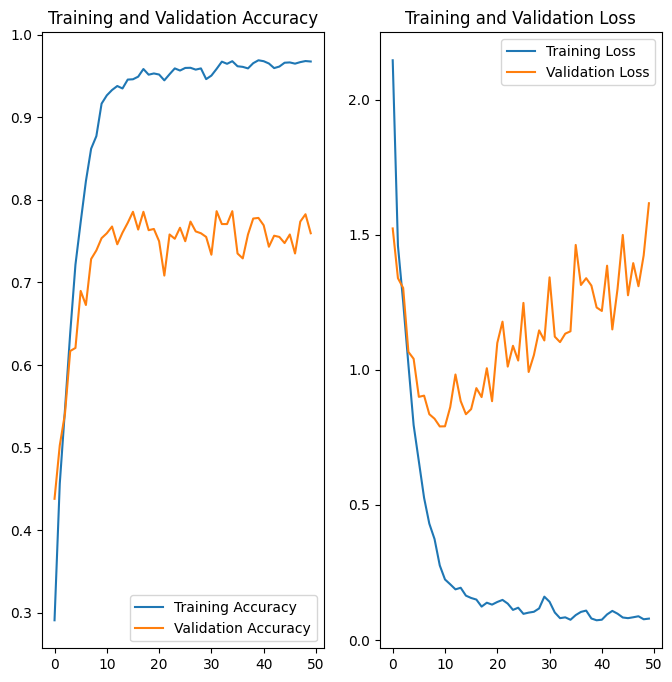

In [57]:
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The graphs indicate that the model has achieved a strong balance between training and validation accuracy, effectively addressing underfitting and overfitting. The convergence of training and validation loss curves suggests successful learning. Class rebalancing appears to have improved performance by ensuring fair representation of all classes. The model demonstrates good generalization to unseen data.